In [8]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors as de
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem import rdMolEnumerator
from rdkit.Chem import Lipinski as lip
from rdkit.Chem import Crippen as cr
from rdkit.Chem import rdmolfiles as rdfiles
import pandas as pd
import matplotlib.pyplot as plt
from vina import Vina
import py3Dmol
from meeko import MoleculePreparation
import os

In [10]:
conformer_path = 'output_conf/'

# Import large number of molecules
    
Using 
    
    rdfolfiles.SmilesMolSupplier() 
    
it is possible to import a large number of molecules in a .smi file from eg ChemDraw or Maestro for further evaluation. If molecules are imported and are not to be modified, jump to generation of 3D coordinates

In [ ]:
#Insert the same of the .smi file located in the root directory
RE7_enumerated = rdfiles.SmilesMolSupplier('Test_export.smi')

#View the imported library
img_import = Draw.MolsToGridImage(RE7_enumerated, molsPerRow = 4, subImgSize = (300,300), legends=[x.GetProp("_Name") for x in RE7_enumerated])
img_import

# Molecular enumeration 


## Use a regi-enumerated molecule as input in the chain enumeration

In [ ]:
#Instead of writing the whole molecule into the Notebook, just import the file
test_1 = Chem.MolFromMolFile('/home/robin/Documents/Learning programming/RDkit/Test-molecule.mol')
test_1

In [ ]:
test_molecule_enumerated_2 = rdMolEnumerator.Enumerate(test_1)
test_molecule_enumerated_2

In [ ]:
#This fuction can be skipped if enumeration is to be done on the imported regio-enumerated molecules
from rdkit.Chem import rdFMCS
def align_bundle_coords(bndl):
    ps = rdFMCS.MCSParameters()
    for m in bndl:
        Chem.SanitizeMol(m)
    mcs = rdFMCS.FindMCS(bndl,completeRingsOnly=True)
    q = Chem.MolFromSmarts(mcs.smartsString)
    rdDepictor.Compute2DCoords(q)
    for m in bndl:
        rdDepictor.GenerateDepictionMatching2DStructure(m,q)

In [ ]:
#Not nesseccery to call the function if the input molecules are to be chain enumerated. 
#Call the function if only regio-enumeration should be viewd
align_bundle_coords(test_molecule_enumerated_2)
Draw.MolsToGridImage(test_molecule_enumerated_2)

output = []
for mol in test_molecule_enumerated_2:
    Chem.MolToSmiles(mol)
    output.append(mol)
output

# Import or generate core and/or reactants

Here, the molecules of interest can be generated individualy as SMILES or imported as a SMILES file. 

In [2]:
Library_alc = rdfiles.SmilesMolSupplier('Alcohols.smi') #Read input file with all reactants
Library_amine = rdfiles.SmilesMolSupplier('Amine.smi')
Library_alkynes = rdfiles.SmilesMolSupplier('alkynes.smi')

# Import reaction library 

The provided reaction library is a Pandas DataFrame. It is accessed as 

    reaction_library
    
This cell only imports the library.

In [3]:
reaction_library = pd.read_csv('Reaction_library_2.csv', index_col='ReactionName')
reaction_library

,ReactionSMARTS
ReactionName,
Primary alc ox,[CH2:1]-O >> [C:1]=O
Amide coupling,[C:1](=[O:2])O.[N:3] >> [C:1](=[O:2])[N:3]
Diels-Alder,'[C:1]=[C:2]-[C:3]=[C:4].[C:5]=[C:6] >> [C:5]-...
4Click,[N:1]=[N+1:2]=[N-1:3].[CH:4]#[C:5]>>[N:1]-1-[C...
Esterification,[C:1](=[O:2])O.[O:3] >> [C:1](=[O:2])[O:3]


# Single molecule reactions/modification

Here, the input only undergoes an intramolecular modification i.e no additional reactant is added.

In [74]:
def unimolecular_rxn(SM, reaction_SMIRKS):
    '''Input the reactant and the reaction SMIRKS and react each reactant according to the defined SMARTS reaction in the function'''

    #reaction3 = '[CH2:1]-O >> [C:1]=O'
    rxn2 = AllChem.ReactionFromSmarts (reaction_SMIRKS)
    product = rxn2.RunReactants([SM,])
    
    resulting_smile_list = []
    try:
        for i in range(len(product)):
            resulting_smile = Chem.MolToSmiles(product[i][0])
            resulting_smile_list.append(resulting_smile)
    except:
        pass
    return resulting_smile_list
    

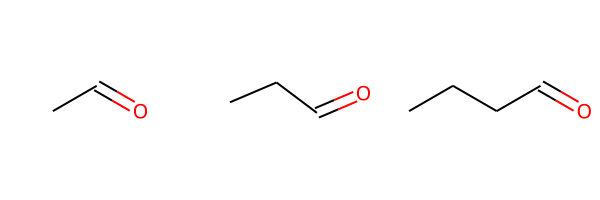

In [75]:
reaction = reaction_library.ReactionSMARTS['Primary alc ox'] #Define the reaction type
reaction

products = []
for i in Library_alc: #Pass the name of the input library
    prod = unimolecular_rxn(i, reaction)
    # print(prod)
    for mol in prod:
        product = Chem.MolFromSmiles(mol)
        products.append(product)
        # print(product)


Draw.MolsToGridImage(products)


# React two compound 

Here, two compounds are allowed to react but where one is defined as the core and the other reactant is itterated over an input list of smiles.

In [5]:
def bimolecular_rxn(mol1, mol2, reaction):
    '''The function takes two input arguments where one is defined as a molecular core to be enumarated'''
    rxn3 = AllChem.ReactionFromSmarts (reaction)
    products = rxn3.RunReactants ([mol1, mol2])
    resulting_smile_list = []
    try:
        for i in range(len(products)):
            resulting_smile = Chem.MolToSmiles(products[i][0])
            resulting_smile_list.append(resulting_smile)
    except:
        pass
    return resulting_smile_list

# Run reaction


In [ ]:
reaction_type = reaction_library.ReactionSMARTS["4Click"] #Define the reaction type from the reaction library
product_click = [] #List of enumerated molecules
Core = Chem.MolFromSmiles('O[C@@H]1[C@@H](O)[C@H](OCC2=CC=CC=C2)[C@H](O[C@H]1N=[N+]=[N-])C(O)=O') #Define the molecular core

for i in Library_alkynes: #Read the .smi-file of reagents to be used for enumeration
    resulting_smiles = bimolecular_rxn(Core, i, reaction_type)
    
    for i in resulting_smiles:
        prod1 = Chem.MolFromSmiles(i)
        product_click.append(prod1)

Draw.MolsToGridImage(product_click, maxMols=999)

# Lipinski rules

The Lipinski rules of five, https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five, are here used on the generated data set to sort out potential drug candidates.

 ### Here, the module is used to calculate chemical features

    de.ExactMolWt() Calculates the exact molar mass of the molecule
    lip.NumHAcceptors() Calculates the hydrogen bond acceptors
    lip.NumHDonors() Calculates the number of hydrogen bond donors
    cr.MolLogP() Caluclates the logP value
    

passed_molecules = []
testlist = []

for i in product_click: #Read enumerated data set
    '''Set the target molecular weight of the dataset'''
    if de.ExactMolWt(i) < 1500: #Set the Mw cut off value
        #passed_molecules.append(i)
        '''Set the numer of hydrogen bond acceptors'''
        if 0 < lip.NumHAcceptors(i) <= 18: #Set the value of hydrogen bond acceptors cut off values
            '''Set the number of hydrogen bond donors'''
            if 0 <= lip.NumHDonors(i) <= 50: #Set the value of hydrogen bond acceptor cut off values
                '''Calculate logP by setting the values'''
                if -1<= cr.MolLogP(i) <= 10:
                    passed_molecules.append(i)


In [93]:
def lipinski_ro5(mol):
    if de.ExactMolWt(mol) < 1500: #Set the Mw cut off value
        #passed_molecules.append(i)
        '''Set the numer of hydrogen bond acceptors'''
        if 0 < lip.NumHAcceptors(mol) <= 18: #Set the value of hydrogen bond acceptors cut off values
            '''Set the number of hydrogen bond donors'''
            if 0 <= lip.NumHDonors(mol) <= 50: #Set the value of hydrogen bond acceptor cut off values
                '''Calculate logP by setting the values'''
                if -1<= cr.MolLogP(mol) <= 10:
                    return mol


In [94]:
passed_molecules = []

for i in product_click:
    lipinski_ro5(i)
    passed_molecules.append(i)

In [95]:
def molecular_features(mol_Lipinski):
    logP = cr.MolLogP(mol_Lipinski)
    molecular_weight = de.ExactMolWt(mol_Lipinski)
    hydrogen_bond_acc = lip.NumHAcceptors(mol_Lipinski)
    hydrogen_bond_don = lip.NumHDonors(mol_Lipinski)
    TPSA = Chem.Descriptors.TPSA(mol_Lipinski)
    return logP, molecular_weight, hydrogen_bond_acc, hydrogen_bond_don, TPSA

In [96]:
output_featurs = []

for i in passed_molecules:
    calc_molecular_features = molecular_features(i)
    output_featurs.append(calc_molecular_features)



In [98]:
len(passed_molecules)

79

In [ ]:
Draw.MolsToGridImage(passed_molecules, legends = [f"Molecular weight: {feature[1]} \n logP: {feature[0]} \n TPSA: {feature[4]}" for feature in output_featurs], maxMols = 999) 

# Generate 3D coordinates 

The dataset generated above must be converetd into usable 3D coordinates if it is going to be docked into an enzyme using eg. AutoDock Vina. The 3D coordinates are saved as .sdf-files if another docking program is prefered.

In [115]:
conformer = []
for mol in product_click:
    mol = Chem.AddHs(mol)
    a = AllChem.EmbedMolecule(mol)
    if a == -1:
        continue
    AllChem.MMFFOptimizeMolecule(mol, mmffVariant = 'MMFF94', confId = 0)
    conformer.append(mol)
    
if os.path.exists(conformer_path) == True:
    pass
if os.path.exists(conformer_path) == False:
    os.makedirs(conformer_path)

for conf, k in enumerate(conformer, 1):
    a = Chem.SDWriter('output_conf/File{0}.sdf'.format(conf))
    a.write(k)

# Visulize the 3D conformation 

Using py3Dmol.view(), it is possible to view the conformer of each molecule that is generated. 

In [113]:
v = py3Dmol.view()
v.addModel(Chem.MolToMolBlock(conformer[55]))
v.setStyle({'stick':{}})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Generate ligands for docking

The calculated conformer is here converted to a .pdbqt file which is needed for AutoDock. This is done using Meeko

    MolecularPreparation()
        keep_nonpolar_hydrogens=False, Set to true to allow all hydrogens present in moelcule
        hydrate=False,
        flexible_amides=False,
        rigid_macrocycles=False,
        min_ring_size=7,
        max_ring_size=33,
        keep_chorded_rings=False,
        keep_equivalent_rings=False,
        rigidify_bonds_smarts=[],
        rigidify_bonds_indices=[],
        double_bond_penalty=50,
        atom_type_smarts={},
        add_index_map=False,
        stop_at_defaults=False,
        remove_smiles=False

In [ ]:
preparator = MoleculePreparation(keep_nonpolar_hydrogens=True)


for mol, a in enumerate(conformer, 1):
    #Add to check input structure
    preparator.prepare(a)
    preparator.show_setup()
    preparator.write_pdbqt_file('output_conf/File{0}.pdbqt'.format(mol))

# Molecular docking - AutoDock Vina

## Preparation of receptor

The receptor is prepped by calling the script **prepare_receptor** and having a clean .pdb file. Use a text editor to remove water, ligands etc to only keep the native protein.

    Description of command...
         -r   receptor_filename 
        supported file types include pdb,mol2,pdbq,pdbqs,pdbqt, possibly pqr,cif
    Optional parameters:
        [-v]  verbose output (default is minimal output)
        [-o pdbqt_filename]  (default is 'molecule_name.pdbqt')
        [-A]  type(s) of repairs to make: 
             'bonds_hydrogens': build bonds and add hydrogens 
             'bonds': build a single bond from each atom with no bonds to its closest neighbor
             'hydrogens': add hydrogens
             'checkhydrogens': add hydrogens only if there are none already
             'None': do not make any repairs 
             (default is 'None')
        [-C]  preserve all input charges ie do not add new charges 
             (default is addition of gasteiger charges)
        [-p]  preserve input charges on specific atom types, eg -p Zn -p Fe
        [-U]  cleanup type:
             'nphs': merge charges and remove non-polar hydrogens
             'lps': merge charges and remove lone pairs
             'waters': remove water residues
             'nonstdres': remove chains composed entirely of residues of
                      types other than the standard 20 amino acids
             'deleteAltB': remove XX@B atoms and rename XX@A atoms->XX
             (default is 'nphs_lps_waters_nonstdres') 
        [-e]  delete every nonstd residue from any chain
              'True': any residue whose name is not in this list:
                      ['CYS','ILE','SER','VAL','GLN','LYS','ASN', 
                      'PRO','THR','PHE','ALA','HIS','GLY','ASP', 
                      'LEU', 'ARG', 'TRP', 'GLU', 'TYR','MET', 
                      'HID', 'HSP', 'HIE', 'HIP', 'CYX', 'CSS']
              will be deleted from any chain. 
              NB: there are no  nucleic acid residue names at all 
              in the list and no metals. 
             (default is False which means not to do this)
        [-M]  interactive 
             (default is 'automatic': outputfile is written with no further user input)
        [-d dictionary_filename] file to contain receptor summary information
        [-w]   assign each receptor atom a unique name: newname is original name plus its index(1-based)



In [ ]:
#Prepare recepror file using prepare_receptor.py 
#Enter the input parameters for the receptor input .pdb-file

!/home/robin/ADFRsuite-1.0/bin/prepare_receptor -r 'receptor_input.pdb' -o 'receptor_output.pdbqt'

#If a flexible docking is to be preformed, the receptor must be prepared for that by running 


## Docking the ligands 

In [ ]:
v = Vina(sf_name='vina') #Set forcefield, here 'vina' is selected

v.set_receptor('1iep_receptor.pdbqt')

v.set_ligand_from_file('1iep_ligand.pdbqt')

In [ ]:
v.compute_vina_maps(center=[15.190, 53.903, 16.917], box_size=[20, 20, 20])

# Score the current pose
energy = v.score()
print('Score before minimization: %.3f (kcal/mol)' % energy[0])

# Minimized locally the current pose
energy_minimized = v.optimize()
print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)

# Dock the ligand
v.dock(exhaustiveness=32, n_poses=20)
v.write_poses('1iep_ligand_vina_out.pdbqt', n_poses=5, overwrite=True)

# Plot data 

Here, the molecular features are plotted as a scattered plot

In [ ]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(RE7_enumerated_logP, RE7_enumerated_TPSA, 'rs', label = 'Non-filtered ')
ax.plot(logP_list, TPSA_filtered_lib, 'bo', label = 'Filtered')
ax.set_xlabel('logP', size = 16)
ax.set_ylabel('TPSA', size = 16)
ax.set_title ('logP vs. TPSA for imported molecules', size = 18)
ax.legend()

